In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Loading images from data
# WIN path
#PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/data/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))
image_csv = pd.read_csv(PATH+'Raw_Data_JPG.csv')
CLASS_NAME = image_csv.Diagnosis.unique()
print(image_num)
print(CLASS_NAME)

5110
['No Finding' 'TB' 'Heart' 'CA lung' 'Intra' 'Extra']


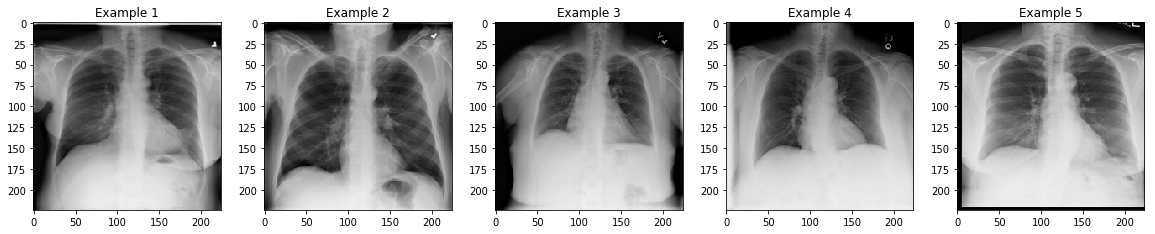

In [4]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [5]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME))
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME))

x_train,y_train = next(data_gen_train)
x_test,y_test = next(data_gen_test)

Found 4088 images belonging to 6 classes.
Found 1022 images belonging to 6 classes.


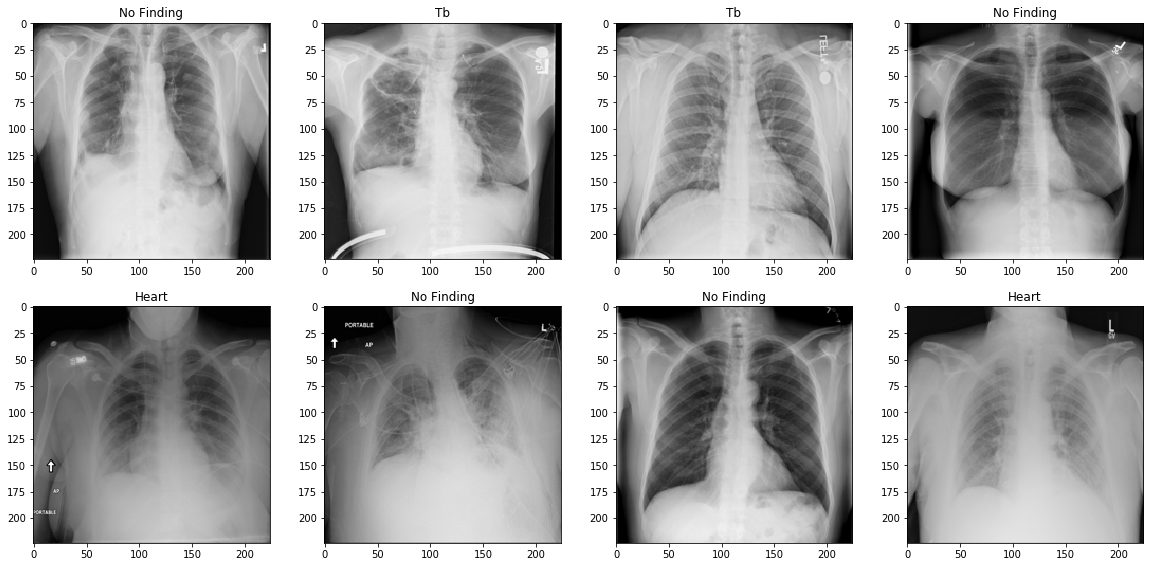

In [6]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[y_train[n]==1][0].title())
    plt.imshow(x_train[n])

In [7]:
#Try to load InceptionV3
myInception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=6)
#for layer in myInception.layers:
#    layer.trainable = False

In [8]:
#Add layers configuration suitable for our model
#This is THE endgame for our project . Carefully review your stradigies 
# Current layers stacking is Awful . Inaccurate with fake accuracy

out = myInception.output
out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
out = layers.Dense(512,activation='relu')(out)
out = layers.Dropout(0.3)(out)
out = layers.Dense(1,activation='hard_sigmoid')(out)

myModel = Model(myInception.input,out)

In [19]:
#myModel.summary()

In [10]:
myModel.compile(loss='binary_crossentropy',
                    optimizer='sgd',metrics=['accuracy'])

In [12]:
#Try to fit data into our model
STEP_PER_EPOCH = np.ceil(4088/32)
session = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_test,
                               epochs = 150,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 20,
                               verbose = 1,)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 20 steps
Epoch 1/150
128/128 [==============================] - 50s 393ms/step - loss: 0.5045 - accuracy: 0.8092 - val_loss: 0.4592 - val_accuracy: 0.8333
Epoch 2/150
128/128 [==============================] - 34s 263ms/step - loss: 0.4636 - accuracy: 0.8333 - val_loss: 0.4553 - val_accuracy: 0.8333
Epoch 3/150
128/128 [==============================] - 33s 258ms/step - loss: 0.4581 - accuracy: 0.8333 - val_loss: 0.4549 - val_accuracy: 0.8333
Epoch 4/150
128/128 [==============================] - 33s 258ms/step - loss: 0.4565 - accuracy: 0.8333 - val_loss: 0.4540 - val_accuracy: 0.8333
Epoch 5/150
128/128 [==============================] - 33s 259ms/step - loss: 0.4551 - accuracy: 0.8333 - val_loss: 0.4541 - val_accuracy: 0.8333
Epoch 6/150
128/128 [==============================] - 33s 258ms/step - loss: 0.4548 - accuracy: 0.

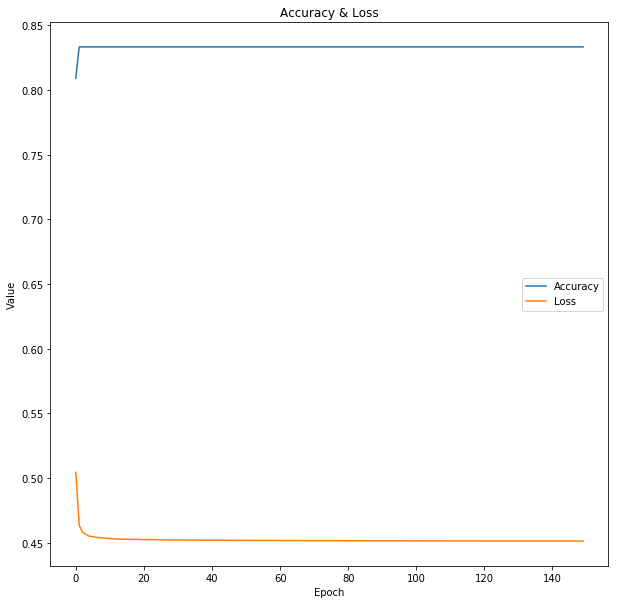

In [13]:
plt.figure(figsize=(10,10))
plt.plot(session.history['accuracy'])
plt.plot(session.history['loss'])
plt.title('Accuracy & Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'])
plt.show()

In [14]:
STEP_PER_EPOCH = np.ceil(1022/32)
test_session = myModel.predict_generator(data_gen_test,STEP_PER_EPOCH)

Instructions for updating:
Please use Model.predict, which supports generators.


In [17]:
num = 0
for i in range(0,test_session.size):
    if(test_session[i] > 0.1):
        num+=1
num

1021

In [18]:
test_session

array([[0.14983684],
       [0.17148152],
       [0.15348068],
       ...,
       [0.18005487],
       [0.1745868 ],
       [0.18331614]], dtype=float32)